# Cumulative flow

Surface flow algorithms rely on the interconnection of nodes to pass information from one node to another in a downhill direction. Some algorithms include multiple downhill pathways where information is passed from a parent node to more than one downhill neighbours. Flow is split among $N$ downhill neighbours using

$$
\frac{Q_i}{Q_{\mathrm{total}}} = \frac{S_i^\alpha}{\sum_{i=1}^{N} S_i^{\alpha}}
$$

where $Q_{\mathrm{total}}$ is the total water discharge flowing through the node, $Q_i$ is the discharge into the immediate downstream node, $S$ is the local slope, $i$, and $\alpha$ is a partitioning parameter (usually $\alpha=\frac{1}{2}$). This notebook explores the propagation of information to downstream areas using one or two pathways.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import clock
%matplotlib inline

from quagmire import TopoMesh # all routines we need are within this class
from quagmire import tools as meshtools

In [20]:
minX, maxX = -5.0, 5.0
minY, maxY = -5.0, 5.0

x, y, bmask, = meshtools.elliptical_mesh(minX, maxX, minY, maxY, 0.05, 0.05, samples=20000, boundary_samples=500)
x, y = meshtools.lloyd_mesh_improvement(x, y, bmask, iterations=5)

radius  = np.sqrt((x**2 + y**2))
theta   = np.arctan2(y,x)
height  = np.exp(-0.01 *(x**2 + y**2)**2) + 0.25 * (0.2*radius)**8  * np.cos(30.0*theta)**2 ## Concentrated
height  = np.exp(-0.025*(x**2 + y**2)**2) + 0.25 * (0.2*radius)**4  * np.cos(30.0*theta)**2 ## Less so

height  += 0.5 * (1.0-0.2*radius)

# height  += 0.05 * np.random.random(height.shape)

print height.max(), height.min()

Origin =  0.0 0.0 Radius =  5.0 Aspect =  1.0
1.49984152758 0.000489764705867


In [21]:
dm = meshtools.create_DMPlex_from_points(x, y, bmask)

mesh = TopoMesh(dm)
mesh.update_height(height)

 - Delaunay triangulation 0.133519s
 - cKDTree 0.003933s
 - Calculate node weights and area 0.24343s
 - Compute edge lengths 0.029416s
 - Construct nearest neighbour array 0.120729s
 - Construct neighbour cloud array 0.103383s
 - Find boundaries 0.004225s
 - Build smoothing matrix 0.007072s
 - Sort nodes by field 0.032794s
 - Build downhill matrices 0.081909s


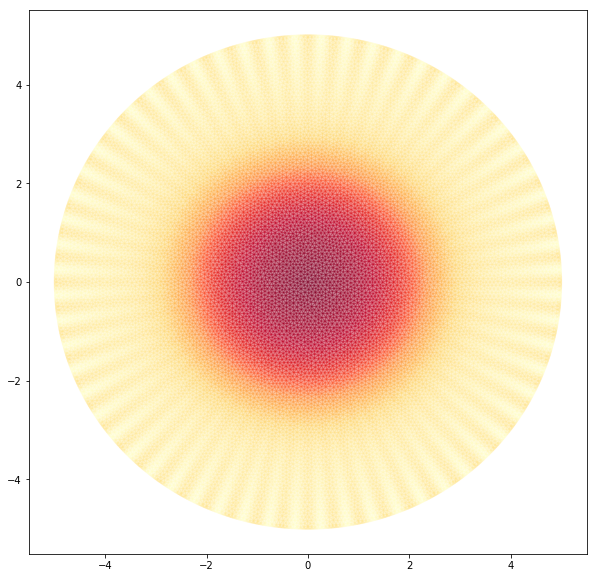

In [22]:
fig, (ax1) = plt.subplots(1,1, figsize=(10,10))
ax1.tripcolor(x, y, mesh.tri.simplices, height, cmap='YlOrRd', 
              shading='gouraud', alpha=0.5, zorder=1)


## One, two or all downhill neighbours

We can build different variants of the downhill propagation matrix including different numbers of downhill neighbours -- one, two (the default) or all.

 1. The `downhillMat` matrix houses the downstream neighbour network. It is the (weighted) sum of two matrices `adjacency1` and `adjacency2` which contain the first and second neighbours respectively. Below we replace `downhillMat` with `adjacency1`.
 
 2. This is the default setting in Quagmire. It uses the partitioning algorithm above to split information among downhill neighbours. If there is only one downhill neighbour then all the flow is directed to that node.

 3. Now we split flow into all downhill neighbours. There may be several recipient nodes that are lower than the parent node depending on the unstructured mesh.
 
The test surface is a smooth hill that runs down into a corrugated plain. A uniform runoff pattern should fill each of the channels at the outflow position equally. 

In [23]:
mesh._build_adjacency_matrix_1()
down1 = mesh.adjacency1.copy()
mesh.downhillMat = down1
down1T = down1.copy().transpose()

print "No of local minima = ", np.count_nonzero(down1T.getRowSum().array == 0.0)


No of local minima =  61


In [24]:
down1T.getDiagonal().array

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [25]:
from mpi4py import MPI
import sys,petsc4py
petsc4py.init(sys.argv)
from petsc4py import PETSc
from time import clock
comm = MPI.COMM_WORLD


vec = mesh.gvec.copy()
vec.setArray(mesh.slope*0.0+0.5)

diagmat = PETSc.Mat().create(comm)
diagmat.setType('aij')
diagmat.setSizes(mesh.sizes)
diagmat.setPreallocationNNZ(mesh.sizes[0])
diagmat.setDiagonal(vec)



In [26]:
mesh._build_downhill_matrix_new()
down2 = mesh.downhillMat.copy()

In [27]:
mesh._build_downhill_matrix_neighbours()
downN = mesh.downhillMat.copy()

In [28]:
def downhill_propagation(downhillMat, vector):
    """ time the propagation of information downhill """
    mesh.downhillMat = downhillMat
    t = clock()
    cumvec = mesh.cumulative_flow(vector)
    return cumvec, clock() - t

upstream_area_1n, t_1n = downhill_propagation(down1, mesh.area)
upstream_area_2n, t_2n = downhill_propagation(down2, mesh.area)
upstream_area_Nn, t_Nn = downhill_propagation(downN, mesh.area)

## Comparison plot

Max Area 1,2,N:  2.00211337258 1.86235922325 1.37440322929


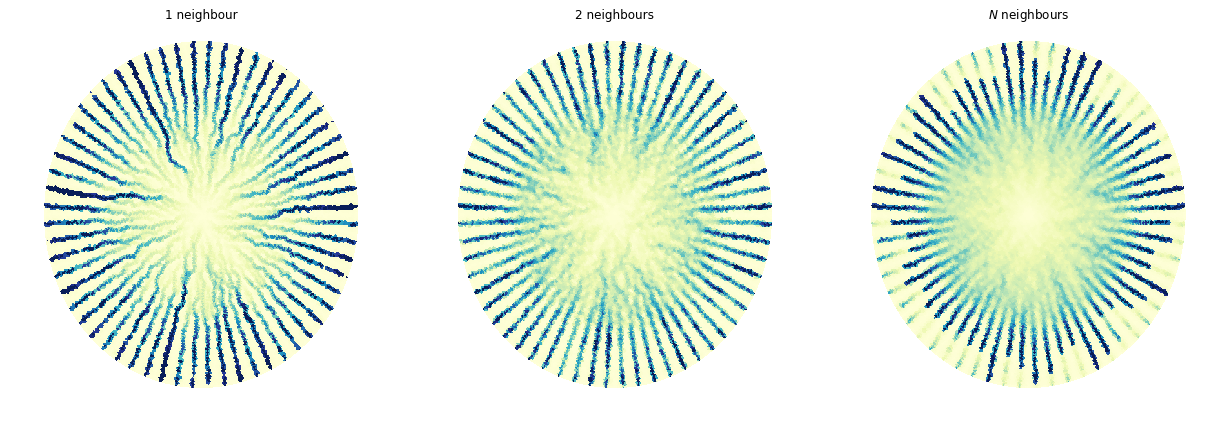

In [29]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(21,7))
for ax in [ax1,ax2,ax3]:
    ax.axis('off')

vmax = np.mean([upstream_area_1n.max(), upstream_area_2n.max(), upstream_area_Nn.max()])
print "Max Area 1,2,N: ", upstream_area_1n.max(), upstream_area_2n.max(), upstream_area_Nn.max()

vmax=0.5

im1 = ax1.tripcolor(x, y, mesh.tri.simplices, upstream_area_1n, cmap='YlGnBu', vmax=vmax)
im2 = ax2.tripcolor(x, y, mesh.tri.simplices, upstream_area_2n, cmap='YlGnBu', vmax=vmax)
im3 = ax3.tripcolor(x, y, mesh.tri.simplices, upstream_area_Nn, cmap='YlGnBu', vmax=vmax)

ax1.set_title('1 neighbour')
ax2.set_title('2 neighbours')
ax3.set_title('$N$ neighbours')

plt.show()

## Movie: One downhill neighbour

In [ ]:
import matplotlib.animation as manimation
FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
        comment='Movie support!')
writer = FFMpegWriter(fps=24, codec='libx264', bitrate=2000, metadata=metadata)


DX0 = mesh.gvec.duplicate()
DX1 = mesh.gvec.duplicate()
DX1.set(1.0)

plt.ion()
fig = plt.figure(1, figsize=(5,5))
ax1 = fig.add_subplot(111, xlim=[minX,maxX], ylim=[minY,maxY])
ax1.axes.set_aspect("equal")
ax1.axis('off')
ax1.triplot(x, y, mesh.tri.simplices, color="Black", linewidth=0.1, alpha=0.5, zorder=0)
im1 = ax1.tripcolor(x, y, mesh.tri.simplices, DX1.array, vmin=0, vmax=1, cmap='YlOrRd', shading='gouraud', alpha=0.5, zorder=1)

step=0
DXsum0 = DX1.sum()
with writer.saving(fig, 'sombrero_1n.mp4', 100):
    while DX1.sum() > DXsum0 * 1.0e-8 and step < 250: 
                
        im1.set_array(DX1.array)
        fig.canvas.draw()
        writer.grab_frame()

        if step%10 == 0:
            print "step {:05d} -  remaining information  {:.3f}".format(step, DX1.sum())

        step += 1

        DX1 = mesh.downhillMat*DX1
        DX0 += DX1
        
plt.close()

print "Terminated after {} steps".format(step)

## Movie: Two downhill neighbours


In [ ]:
DX0 = mesh.gvec.duplicate()
DX1 = mesh.gvec.duplicate()
DX1.set(1.0)

plt.ion()
fig = plt.figure(1, figsize=(5,5))
ax1 = fig.add_subplot(111, xlim=[minX,maxX], ylim=[minY,maxY])
ax1.axes.set_aspect("equal")
ax1.axis('off')
ax1.triplot(x, y, mesh.tri.simplices, color="Black", linewidth=0.1, alpha=0.5, zorder=0)
im1 = ax1.tripcolor(x, y, mesh.tri.simplices, DX1.array, vmin=0, vmax=1, cmap='YlOrRd', shading='gouraud', alpha=0.5, zorder=1)

step=0

DXsum0 = DX1.sum()
with writer.saving(fig, 'sombrero_2n.mp4', 100):
    while DX1.sum() > DXsum0 * 1.0e-8 and step < 250: 
                
        im1.set_array(DX1.array)
        fig.canvas.draw()
        writer.grab_frame()

        if step%10 == 0:
            print "step {:05d} -  remaining information  {:.3f}".format(step, DX1.sum())

        step += 1

        DX1 = mesh.downhillMat*DX1
        DX0 += DX1
        
plt.close()

print "Terminated after {} steps".format(step)

## Movie $N$ downhill neighbours


In [ ]:
DX0 = mesh.gvec.duplicate()
DX1 = mesh.gvec.duplicate()
DX1.set(1.0)

plt.ion()
fig = plt.figure(1, figsize=(5,5))
ax1 = fig.add_subplot(111, xlim=[minX,maxX], ylim=[minY,maxY])
ax1.axes.set_aspect("equal")
ax1.axis('off')
ax1.triplot(x, y, mesh.tri.simplices, color="Black", linewidth=0.1, alpha=0.5, zorder=0)
im1 = ax1.tripcolor(x, y, mesh.tri.simplices, DX1.array, vmin=0, vmax=1, cmap='YlOrRd', shading='gouraud', alpha=0.5, zorder=1)

step=0
DXsum0 = DX1.sum()

with writer.saving(fig, 'sombrero_Nn.mp4', 100):
    while DX1.sum() > DXsum0 * 1.0e-8 and step < 250: 

                
        im1.set_array(DX1.array)
        fig.canvas.draw()
        writer.grab_frame()

        if step%10 == 0:
            print "step {:05d} -  remaining information  {:.3f}".format(step, DX1.sum())

        step += 1

        DX1 = mesh.downhillMat*DX1
        DX0 += DX1

plt.close()

print "Terminated after {} steps".format(step)

## Compare upstream area

Examine the difference in upstream area for the three neighbour combinations.

$$
A_{\mathrm{upstream}} = \int_{\mathrm{upstream}} \!\!\!\! A(\xi) \, \mathrm{d}\xi
$$

## Timings

The number of iterations to propogate information out of the domain increases with the number of downhill neighbours. One downhill neighbour is the fastest, yet the least realistic. Two downhill neighbours offers a good compromise between realistic flow and computation time.

In [32]:
def timed_downhill_propagation(downhillMat, vector):
    """ time the propagation of information downhill """
    mesh.gvec.setArray(vector)
    DX0 = mesh.gvec.copy()
    DX1 = mesh.gvec.copy()

    DX1_sum = DX1.sum()
    tt = [0.]
    ua = [DX1_sum]
    
    step = 0
    DX1_sum0 = DX1_sum
    
    t = clock()

    while DX1_sum > 1e-8 * DX1_sum0:
        
        DX1 = downhillMat*DX1
        DX0 += DX1
        DX1_sum = DX1.sum()
        
        tt.append(clock() - t)
        ua.append(DX1_sum)
        step += 1

        # print DX1_sum, DX1_sum0, step
        
    return ua, tt

ua_1n, tt_1n = timed_downhill_propagation(down1, mesh.area)
ua_2n, tt_2n = timed_downhill_propagation(down2, mesh.area)
ua_Nn, tt_Nn = timed_downhill_propagation(downN, mesh.area)

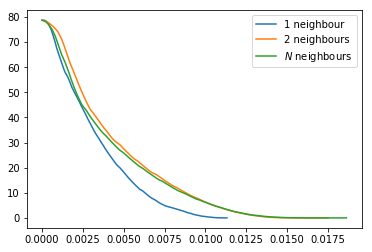

In [33]:
fig = plt.figure(1)
ax1 = fig.add_subplot(111)
ax1.plot(tt_1n, (ua_1n), label='1 neighbour')
ax1.plot(tt_2n, (ua_2n), label='2 neighbours')
ax1.plot(tt_Nn, (ua_Nn), label='$N$ neighbours')
plt.legend()
plt.show()

## Changing path length without changing the mesh

An interesting comparison of the different downhill transport algorithms is to keep the mesh fixed but have arbitrarily longer paths ... we can do this with the magical spiral mountain

In [75]:
radius         = np.sqrt((x**2 + y**2))
theta          = np.arctan2(y,x)
spiral_factor  = 3.0
height  = 1.5 * np.cos(2.0*theta+spiral_factor*radius)**2 
height  += 2.0 * (1.0-0.2*radius)


print height.max(), height.min()

3.46661966084 -0.00199507018194


In [76]:
mesh.update_height(height)

 - Sort nodes by field 0.038917s
 - Build downhill matrices 0.088324s


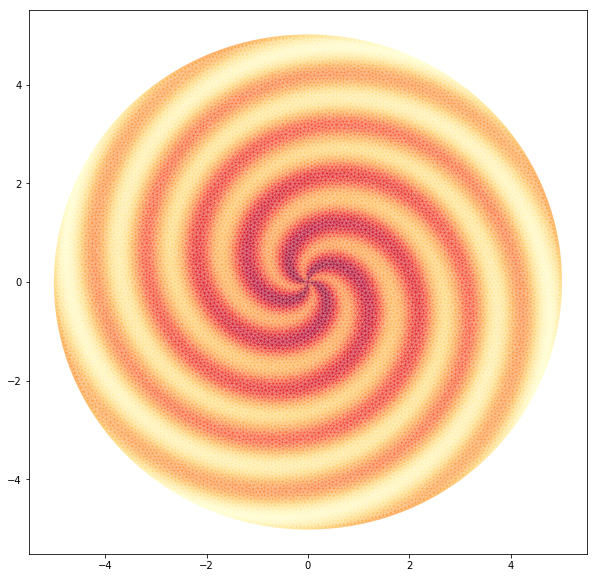

In [77]:
fig, (ax1) = plt.subplots(1,1, figsize=(10,10))
ax1.tripcolor(x, y, mesh.tri.simplices, height, cmap='YlOrRd', 
              shading='gouraud', alpha=0.5, zorder=1)


In [78]:
mesh._build_adjacency_matrix_1()
down1 = mesh.adjacency1.copy()
mesh.downhillMat = down1

mesh._build_downhill_matrix_new()
down2 = mesh.downhillMat.copy()

mesh._build_downhill_matrix_neighbours()
downN = mesh.downhillMat.copy()

upstream_area_1n, t_1n = downhill_propagation(down1, mesh.area)
upstream_area_2n, t_2n = downhill_propagation(down2, mesh.area)
upstream_area_Nn, t_Nn = downhill_propagation(downN, mesh.area)

In [79]:
upstream_area_1ns = mesh.local_area_smoothing(upstream_area_1n, its=1, centre_weight=0.75)

Max Area 1,2,N:  19.7009374643 18.4681764575 1.45021667607


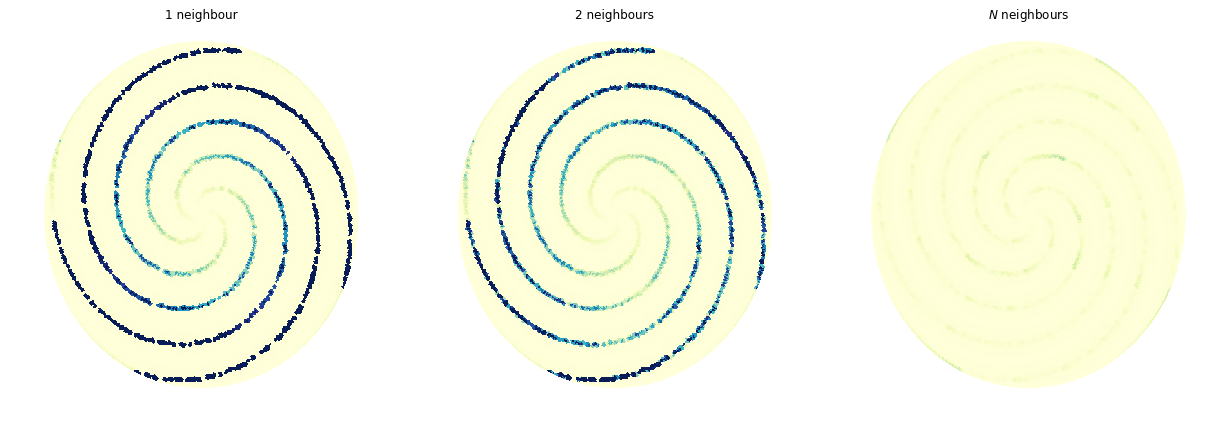

In [82]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(21,7))
for ax in [ax1,ax2,ax3]:
    ax.axis('off')

vmax = 0.25 * np.mean([upstream_area_1n.max(), upstream_area_2n.max(), upstream_area_Nn.max()])
print "Max Area 1,2,N: ", upstream_area_1n.max(), upstream_area_2n.max(), upstream_area_Nn.max()

im1 = ax1.tripcolor(x, y, mesh.tri.simplices, upstream_area_1n, cmap='YlGnBu', vmax=vmax)
im2 = ax2.tripcolor(x, y, mesh.tri.simplices, upstream_area_2n, cmap='YlGnBu', vmax=vmax)
im3 = ax3.tripcolor(x, y, mesh.tri.simplices, upstream_area_Nn, cmap='YlGnBu', vmax=vmax)

ax1.set_title('1 neighbour')
ax2.set_title('2 neighbours')
ax3.set_title('$N$ neighbours')

plt.show()

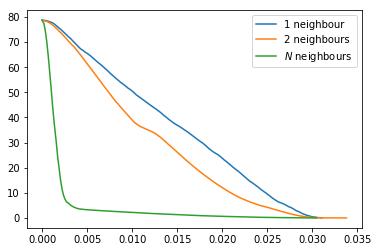

In [83]:
ua_1n, tt_1n = timed_downhill_propagation(down1, mesh.area)
ua_2n, tt_2n = timed_downhill_propagation(down2, mesh.area)
ua_Nn, tt_Nn = timed_downhill_propagation(downN, mesh.area)

fig = plt.figure(1)
ax1 = fig.add_subplot(111)
ax1.plot(tt_1n, (ua_1n), label='1 neighbour')
ax1.plot(tt_2n, (ua_2n), label='2 neighbours')
ax1.plot(tt_Nn, (ua_Nn), label='$N$ neighbours')
plt.legend()
plt.show()

In [ ]:
down1T = down1.copy().transpose()
low_points =  np.where(down1T.getRowSum().array == 0.0)[0]

print "number of low points", low_points.shape[0]

In [ ]:
fig, (ax1) = plt.subplots(1,1, figsize=(21,21))

im1 = ax1.tripcolor(x, y, mesh.tri.simplices, upstream_area_1n, cmap='YlGnBu', vmax=vmax)
# im2 = ax2.tripcolor(x, y, mesh.tri.simplices, upstream_area_2n, cmap='YlGnBu', vmax=vmax)
# im3 = ax3.tripcolor(x, y, mesh.tri.simplices, upstream_area_Nn, cmap='YlGnBu', vmax=vmax)

# ax1.tripcolor(x, y, mesh.tri.simplices, height, cmap='YlOrRd', 
#               shading='gouraud', alpha=0.5, zorder=1)

# ax1.scatter(x, y, s=1, marker=".")
ax1.scatter(x[low_points], y[low_points], s=250.0, marker="x")
